In [249]:
import pickle
import re
import networkx as nx
import pandas as pd
import nltk
import json
import matplotlib.pyplot as plt
import collections
import math

In [171]:
with open('../week4/character_graph', 'rb') as f:
  G = pickle.load(f)

df_characters = pd.read_csv("../week6/zelda-characters-complete.csv")

**Exercise 1 Preprocessing the ZeldaWiki text. Follow the bullets below for each character in your character list:**

In [172]:
aliases = {
  "Cherry": "Ancient Oven"
}

In [173]:
def cleanAndCreateTokens(character):
  pattern = "==+?.*?==+"
  stopwords = nltk.corpus.stopwords.words('english')
  stemmer = nltk.WordNetLemmatizer()
  known_problematic_tokens = ["n", "ref", "cite"]

  if character in aliases:
    character = aliases[character]

  with open('../week6/character-texts/{}.txt'.format(character.replace(" ", "_")), 'r') as f:
    text = f.read()

  text = re.sub(pattern, '', text)
  text = text.lower()
  for character in df_characters.Name:
    text = text.replace(character.lower(), '')
  tk = nltk.WordPunctTokenizer()
  tokens = tk.tokenize(text)
  tokens = [t for t in tokens if t not in df_characters.Name.values]
  tokens = [t for t in tokens if t not in stopwords]
  tokens = [t for t in tokens if any(c.isalpha() for c in t)]
  tokens = [t for t in tokens if t not in known_problematic_tokens] # Remove single n characters as we can see we have a lot of these
  tokens = [stemmer.lemmatize(t) for t in tokens]
  return tokens

In [174]:
for character in df_characters.Name:
  tokens = cleanAndCreateTokens(character)
  if character in aliases:
    character = aliases[character]
  with open("character_tokens/{}.json".format(character.replace(" ", "_")), 'w') as f:
    json.dump(tokens, f)


**Exercise 2 Frequency distribution. Now that we have preprocess the ZeldaWiki pages:**

In [175]:
all_tokens = []
for character in df_characters.Name:
  if character in aliases:
    character = aliases[character]
  with open("character_tokens/{}.json".format(character.replace(" ", "_")), 'r') as f:
    tokens = json.load(f)
  all_tokens.extend(tokens)
zelda_text = nltk.Text(all_tokens)

In [176]:
freq = nltk.FreqDist(zelda_text)

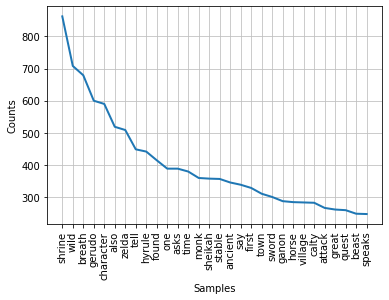

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [177]:
freq.plot(30, cumulative=False)

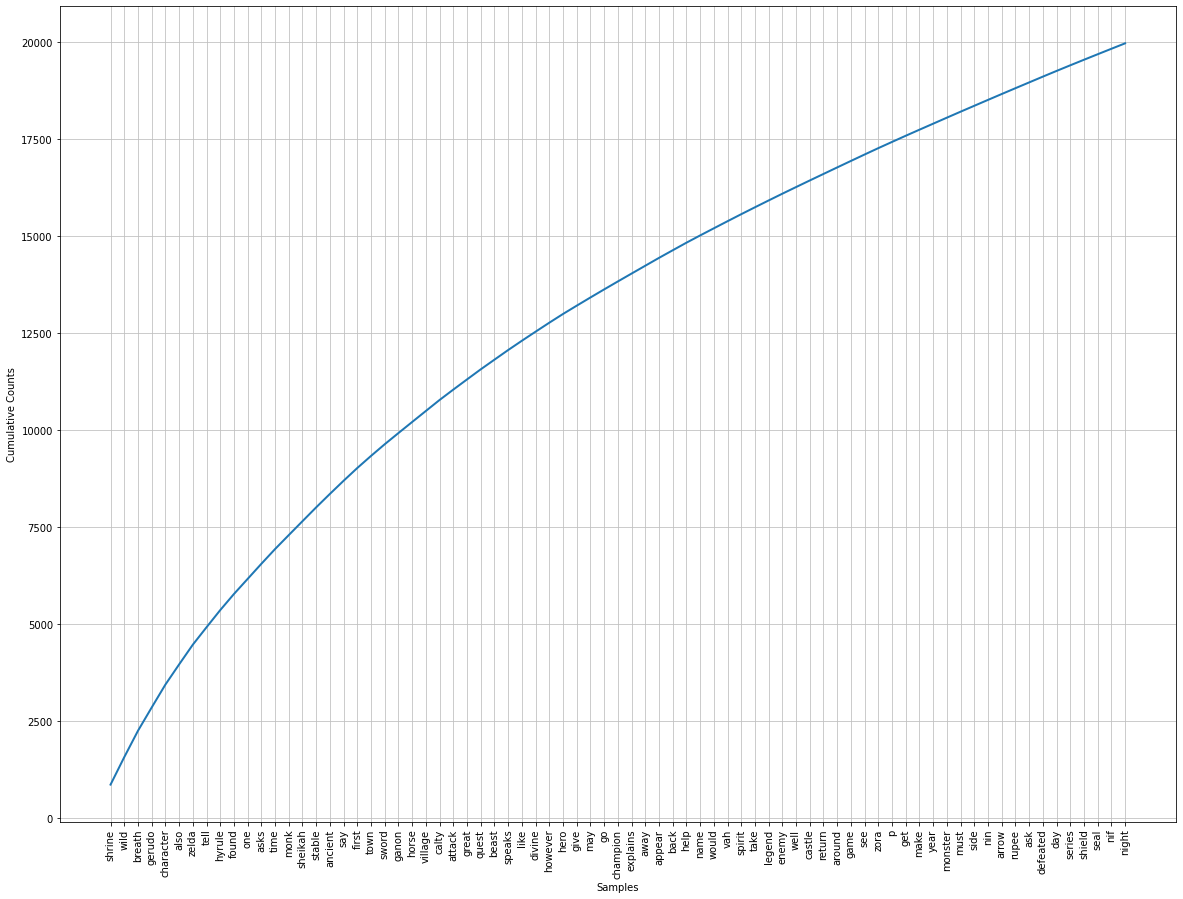

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [178]:
plt.figure(figsize=(20, 15)) 
freq.plot(75, cumulative=True)

We no longer see Link (characters remoed), nor do we see any punctuation. Now however, we see that the most frequent words are the meta-words found in most of the descriptions like 'botw', 'series', 'color', 'name' etc.

# Words that characterize the characters

**Exercise 3: TF-IDF and the characters' race.**


TF-IDF stands for term frequency-inverse document frequency. It is a statistic that is used to determine the importance of a single word to a document in a collection of documents.

In [185]:
races = {key: [] for key in df_characters['Race'].unique()}

In [186]:
for character in df_characters.Name:
  race = df_characters.loc[df_characters["Name"] == character, 'Race'].to_string(index=False)
  if character in aliases:
    character = aliases[character]
  with open("character_tokens/{}.json".format(character.replace(" ", "_")), 'r') as f:
    tokens = json.load(f)
  
  races[race].extend(tokens)

In [224]:
race_tfs = {key: {} for key in df_characters['Race'].unique()}

# Calculate TF for each word
for race, words in races.items():
  for word, count in collections.Counter(words).items():
    race_tfs[race][word] = count / len(words)

In [258]:
df_characters[df_characters['Race'] == "Hylian"]

Name  Role    Race  Gender
0      Baddek  Ally  Hylian    Male
2       Banji  Ally  Hylian  Female
3      Baumar  Ally  Hylian    Male
6      Bolson  Ally  Hylian    Male
7       Brigo  Ally  Hylian    Male
..        ...   ...     ...     ...
545   Sagessa  Ally  Hylian  Female
547      Shay  Ally  Hylian    Male
550     Shibo  Ally  Hylian    Male
552  Tasseren  Ally  Hylian    Male
567      Rola  Ally  Hylian  Female

[215 rows x 4 columns]

In [266]:
def makehash(): # Used to create dict-like structure that does not raise key errors but instead inserts keys if missing
  return collections.defaultdict(makehash)

def default_to_regular(d):
  if isinstance(d, collections.defaultdict):
    d = {k: default_to_regular(v) for k, v in d.items()}
  return d

def number_of_documents_text_appears_in(word, race):
  count = 0
  for character in df_characters[df_characters['Race'] == race].Name:
    if character in aliases:
      character = aliases[character]
    with open("character_tokens/{}.json".format(character.replace(" ", "_")), 'r') as f:
      tokens = json.load(f)
    if word in tokens:
      count += 1
  return count

def total_number_of_documents(race):
  counts = df_characters['Race'].value_counts()
  return counts[race]

race_tfs = makehash()
for race, words in races.items():
  for word, count in collections.Counter(words).items():
    tf = count / len(words)
    idf = math.log(total_number_of_documents(race) / number_of_documents_text_appears_in(word, race))
    race_tfs[race][word]["tf"] = tf
    race_tfs[race][word]["idf"] = idf
    race_tfs[race][word]["tfidf"] = tf * idf


# race_tfs = default_to_regular(race_tfs)

In [288]:
for race, tfs in race_tfs.items():
  top_5_tf = sorted(tfs.items(), key=lambda x: x[1]['tf'], reverse=True)[:5]
  top_5_tfidf = sorted(tfs.items(), key=lambda x: x[1]['tfidf'], reverse=True)[:5]

  print('{}'.format(race))
  print('-----------')

  print("==== TF ====")
  for tf in top_5_tf:
    print('{}'.format(tf[0]))
  print("\n")

  print("==== TFIDF ====")
  for tf in top_5_tfidf:
    print('{}'.format(tf[0]))
  print("\n")

Hylian
-----------
==== TF ====
zelda
stable
wild
hyrule
horse


==== TFIDF ====
zelda
horse
sword
hyrule
triforce


Horse
-----------
==== TF ====
horse
stable
character
lon
ranch


==== TFIDF ====
lon
ranch
seen
get
ocarina


Goron
-----------
==== TF ====
goron
city
yu
vah
rudania


==== TFIDF ====
yu
brother
mine
shrine
calty


Human
-----------
==== TF ====
beetle
ship
sell
membership
item


==== TFIDF ====
recurring
character
legend
zelda
series


Dragon
-----------
==== TF ====
dragon
drop
shard
scale
hyrule


==== TFIDF ====
malice
eldin
power
din
neldin


Rito
-----------
==== TF ====
rito
village
medoh
breath
wild


==== TFIDF ====
song
sister
say
shrine
range


Unknown
-----------
==== TF ====
shrine
ancient
tree
treasure
forest


==== TFIDF ====
tree
treasure
deku
ex
forest


Korok
-----------
==== TF ====
korok
forest
trial
character
breath


==== TFIDF ====
trial
seed
maraca
upgrade
stash


Zora
-----------
==== TF ====
zora
domain
ruta
beast
divine


==== TFIDF ====
ley


Yes they are. The IDF addresses the fact that words that some words are disproportionaly frequent. Terms that occur frequenty in more texts in the collection are negatively effected w.r.t their weight.

Some races share some of their top 5 TFs. For example weapon is used across quite a few races. It is clear through the differences that different races are concerned with difference tokens.

In [265]:
race_tfs

defaultdict(<function __main__.makehash()>,
            {'Hylian': defaultdict(<function __main__.makehash()>,
                         {'character': defaultdict(<function __main__.makehash()>,
                                      {'tf': 0.008043171897019901,
                                       'idf': 0.004662013105811371}),
                          'breath': defaultdict(<function __main__.makehash()>,
                                      {'tf': 0.008318152132815454,
                                       'idf': 0.0}),
                          'wild': defaultdict(<function __main__.makehash()>,
                                      {'tf': 0.009246210428625442,
                                       'idf': 0.0}),
                          'ride': defaultdict(<function __main__.makehash()>,
                                      {'tf': 0.0004124703536933283,
                                       'idf': 3.068052935133617}),
                          'horse': defaultdict(<function _

the IDF was calculated using the natural logarithm. This doesn't matter because the following holds:

loga (x/y) = loga x - loga y

log_a(x)/log_a(y) = log_b(x)/log_b(y)

## WordClouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS

{'Hylian': ['character', 'breath', 'wild', 'ride', 'horse', 'carrying', 'wooden', 'shield', 'traveler', 'sword', 'travel', 'along', 'road', 'serenne', 'stable', 'way', 'tabantha', 'bridge', 'stable', 'back', 'reach', 'stable', 'rest', 'nearby', 'horse', 'moment', 'leaving', 'nwhen', 'spoken', 'reveal', 'great', 'appreciation', 'horse', 'claiming', 'see', 'world', 'horse', 'tinted', 'glass', 'also', 'tell', 'talk', 'horse', 'difficulty', 'speaking', 'others', 'd', 'horse', 'love', 'due', 'much', 'talk', 'horse', 'wife', 'left', 'one', 'mind', 'though', 'give', 'time', 'talk', 'horse', 'nto', 'tng', 'wild', 'horse', 'like', 'adopting', 'new', 'fly', 'member', 'sit', 'say', 'registered', 'horse', 'companion', 'always', 'side', 'die', 'horse', 'one', 'thing', 'travel', 'without', 'long', 'horse', 'say', 'need', 'anything', 'else', 'belief', 'horse', 'important', 'addition', 'state', 'horse', 'saddle', 'fit', 'horse', 'perfectly', 'horse', 'bridle', 'also', 'easy', 'grasp', 'elastic', 'nocc

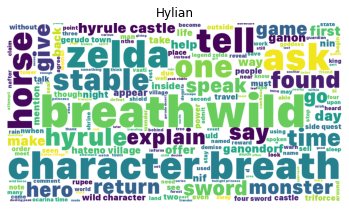

<Figure size 864x720 with 0 Axes>

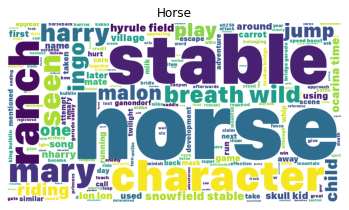

<Figure size 864x720 with 0 Axes>

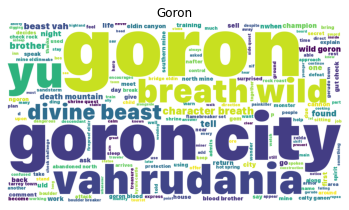

<Figure size 864x720 with 0 Axes>

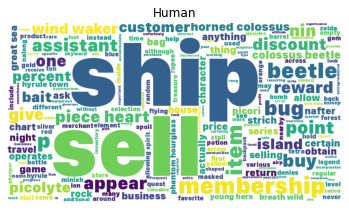

<Figure size 864x720 with 0 Axes>

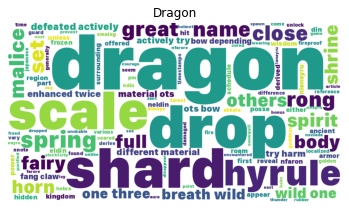

<Figure size 864x720 with 0 Axes>

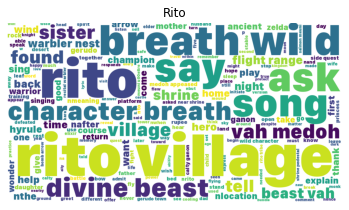

<Figure size 864x720 with 0 Axes>

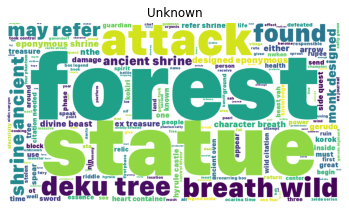

<Figure size 864x720 with 0 Axes>

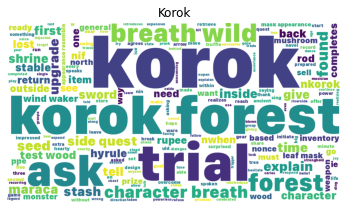

<Figure size 864x720 with 0 Axes>

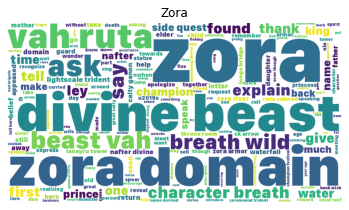

<Figure size 864x720 with 0 Axes>

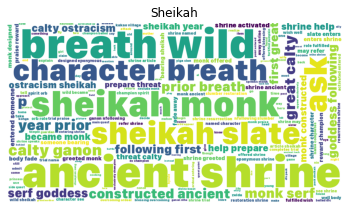

<Figure size 864x720 with 0 Axes>

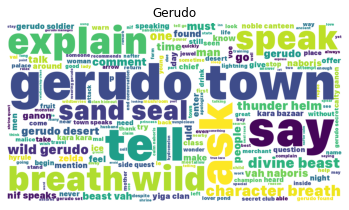

<Figure size 864x720 with 0 Axes>

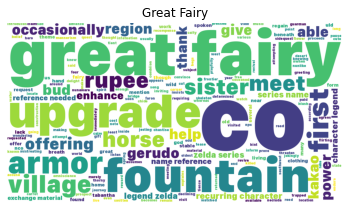

<Figure size 864x720 with 0 Axes>

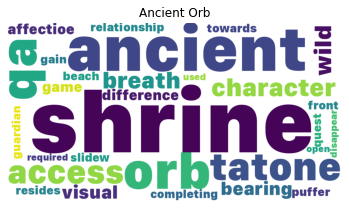

<Figure size 864x720 with 0 Axes>

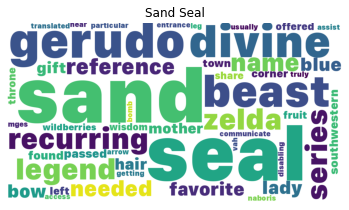

<Figure size 864x720 with 0 Axes>

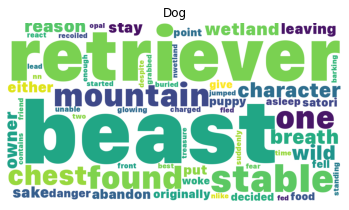

<Figure size 864x720 with 0 Axes>

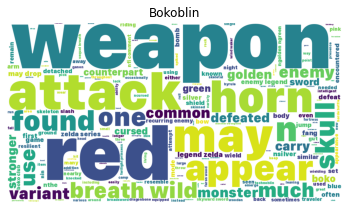

<Figure size 864x720 with 0 Axes>

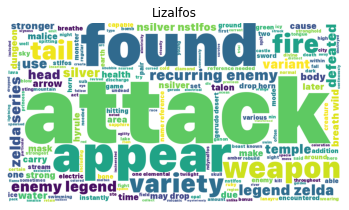

<Figure size 864x720 with 0 Axes>

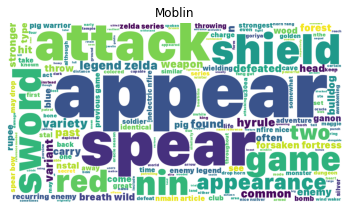

<Figure size 864x720 with 0 Axes>

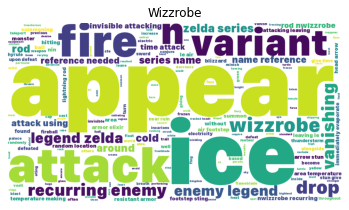

<Figure size 864x720 with 0 Axes>

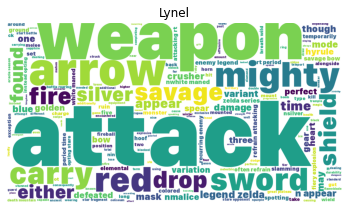

<Figure size 864x720 with 0 Axes>

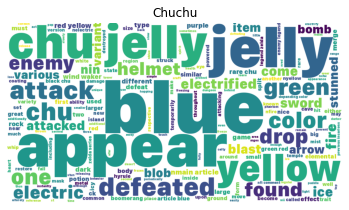

<Figure size 864x720 with 0 Axes>

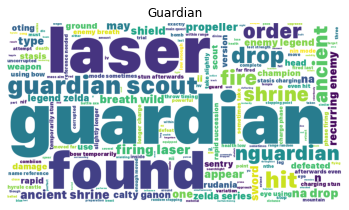

<Figure size 864x720 with 0 Axes>

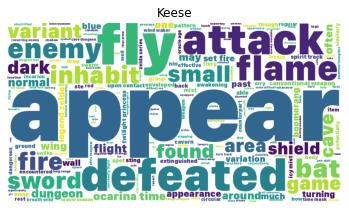

<Figure size 864x720 with 0 Axes>

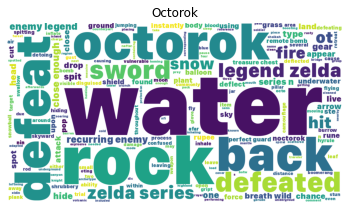

<Figure size 864x720 with 0 Axes>

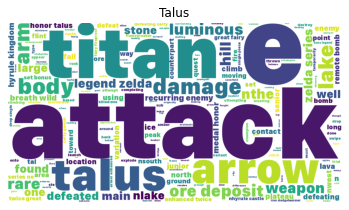

<Figure size 864x720 with 0 Axes>

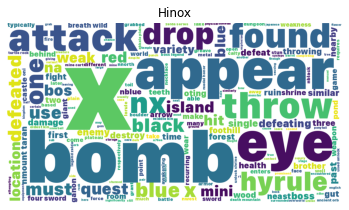

<Figure size 864x720 with 0 Axes>

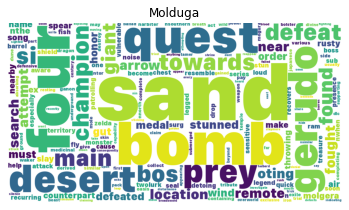

<Figure size 864x720 with 0 Axes>

In [309]:
for race, tokens in races.items():

  wordcloud = WordCloud(
                      font_path='/Library/Fonts/SF-Compact.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1300,
                      height=700,
                     ).generate(" ".join(tokens))

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(race)
  plt.show()